# Anime recommendation program using machine learning


## Management summary

The goal of the project is recommending anime (Japanese Animation film) according to the favourite one of users with the help of machine learning algorithms.  

The data was scraped from https://api.jikan.moe/v4/anime.

The data field consists of:

- title: Anime title
- score: the score given by the community
- scored_by: number of people who rates the anime
- rank: the rank of the anime in the whole list 
- popularity: Popularity of anime (smaller number means higher popularity)
- members: The number of member of the website, who add the anime to their list
- favourites: The number of member of the website, who add the anime to their FAVOURITE list

For the recommendation the project used 2 models: 
1. K-nearest neighbors
2. Hierarchical clustering

Program usage

Step 1: Run the cell, then prompt your favourite anime inside (If you have a list, please seperate them by comma). 

Step 2: Choose the algorithm you want to use. The best is KNN for finding your favourite, it accepts a list of anime. Prompt 'k' for knn. 

Choose hierarchical clustering for a map of how close one is the closest to your favourite (note that it accepts only 1 anime). Prompt 'h' for hierarchical clustering

Step 3: Wait for the result and enjoy your next favorite anime ! 

Overall: 

- Comedy is the most popular genre among all, so it is a good news if you are fond of hilarious stories.

- Fantasy is the second popular genre.

The problem after watching such a good anime and desperately need for a new one that similar is largly solved by this model. Since there is no metrics to evaluate the goodness of the models for unsupervised ML model (from my knowledge only), I will give my personal opinion with experience that those recommendations are excellent. 

## Index:
1. [Data preparation](#data-preparation)
2. [EDA](#eda)
3. [Feature Engineering](#feature-engineering)
4. [KNN](#knn)
5. [Hierarchical Clustering](#hc)
6. [Program](#program)


## Data preparation<a class="anchor" id="data-preparation"></a>

In [1]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import NearestNeighbors
from scipy.sparse import hstack
from sklearn.cluster import AgglomerativeClustering
import scipy.cluster.hierarchy as sch
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
df = pd.read_csv("C:\\Users\\USER\\Anime_Recommendation\\output\\anime_list_20251216_210848.csv")

In [3]:
df

,id,title,score,scored_by,rank,popularity,members,favorites,genres
0,1,Cowboy Bebop,8.75,1041343.0,48.0,42,2016701,88247,"Action, Award Winning, Sci-Fi"
1,2,Cowboy Bebop: Tengoku no Tobira,8.38,228801.0,233.0,651,405049,1756,"Action, Sci-Fi"
2,3,Trigun,8.22,395188.0,387.0,265,818414,17270,"Action, Adventure, Sci-Fi"
3,4,Witch Hunter Robin,7.23,45897.0,3354.0,1982,126459,690,"Action, Drama, Mystery, Supernatural"
4,5,Bouken Ou Beet,6.92,6990.0,4894.0,5776,16496,18,"Action, Adventure, Fantasy"
...,...,...,...,...,...,...,...,...,...
29479,29480,Psyren,NaN,NaN,NaN,13834,1321,3,"Action, Adventure, Romance, Sci-Fi, Supernatur..."
29480,29481,Hareluya II: Boy - Super Hi Video,NaN,NaN,NaN,29330,45,0,Action
29481,29482,Tetsunabe no Jan!,NaN,NaN,NaN,22851,195,1,"Action, Comedy, Gourmet"
29482,29483,"Hachigatsu, Bou, Tsukiakari",NaN,NaN,NaN,29422,5,0,NaN


In [4]:
# Filling missing values
df['genres'] = df['genres'].fillna('')
df['score'] = df['score'].fillna(df['score'].mean())
df['members'] = df['members'].fillna(0)

In [5]:
df.drop(columns =['id'])

,title,score,scored_by,rank,popularity,members,favorites,genres
0,Cowboy Bebop,8.750000,1041343.0,48.0,42,2016701,88247,"Action, Award Winning, Sci-Fi"
1,Cowboy Bebop: Tengoku no Tobira,8.380000,228801.0,233.0,651,405049,1756,"Action, Sci-Fi"
2,Trigun,8.220000,395188.0,387.0,265,818414,17270,"Action, Adventure, Sci-Fi"
3,Witch Hunter Robin,7.230000,45897.0,3354.0,1982,126459,690,"Action, Drama, Mystery, Supernatural"
4,Bouken Ou Beet,6.920000,6990.0,4894.0,5776,16496,18,"Action, Adventure, Fantasy"
...,...,...,...,...,...,...,...,...
29479,Psyren,6.387288,NaN,NaN,13834,1321,3,"Action, Adventure, Romance, Sci-Fi, Supernatur..."
29480,Hareluya II: Boy - Super Hi Video,6.387288,NaN,NaN,29330,45,0,Action
29481,Tetsunabe no Jan!,6.387288,NaN,NaN,22851,195,1,"Action, Comedy, Gourmet"
29482,"Hachigatsu, Bou, Tsukiakari",6.387288,NaN,NaN,29422,5,0,


# EDA <a class="anchor" id="eda"></a>

In [6]:
df.describe()

,id,score,scored_by,rank,popularity,members,favorites
count,29484.000000,29484.000000,1.917200e+04,22253.000000,29484.000000,2.948400e+04,29484.000000
mean,14742.500000,6.387288,2.993442e+04,11121.676268,14711.690103,3.863219e+04,428.875661
std,8511.442005,0.719639,1.222693e+05,6421.131448,8490.719357,1.675980e+05,4520.863085
min,1.000000,1.890000,1.010000e+02,1.000000,1.000000,5.000000e+00,0.000000
25%,7371.750000,6.100000,3.290000e+02,5561.000000,7357.000000,2.330000e+02,0.000000
50%,14742.500000,6.387288,1.513000e+03,11124.000000,14714.500000,1.059000e+03,1.000000
75%,22113.250000,6.630000,9.946500e+03,16683.000000,22060.000000,9.105250e+03,17.000000
max,29484.000000,9.290000,3.005039e+06,22240.000000,29422.000000,4.267738e+06,246039.000000


id                0
title             0
score             0
scored_by     10312
rank           7231
popularity        0
members           0
favorites         0
genres            0
dtype: int64


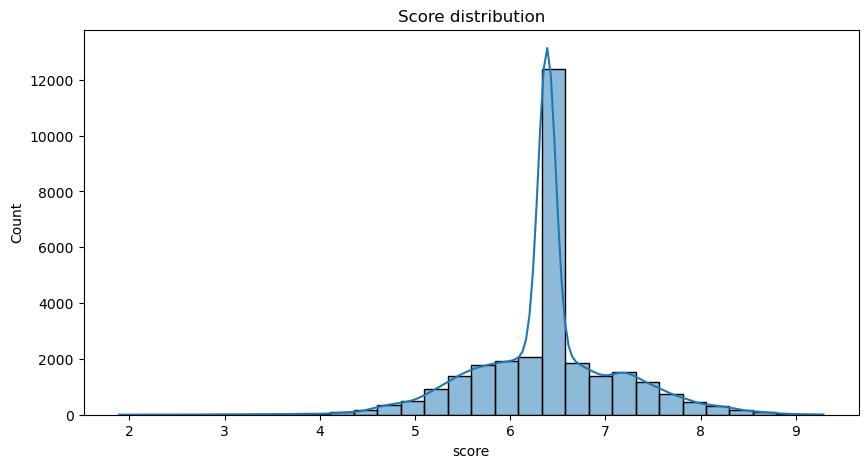

In [7]:
# Check for missing values
print(df.isnull().sum())

# Visualize the distribution of Scores
plt.figure(figsize=(10, 5))
sns.histplot(df['score'].dropna(), bins=30, kde=True)
plt.title('Score distribution')
plt.show()

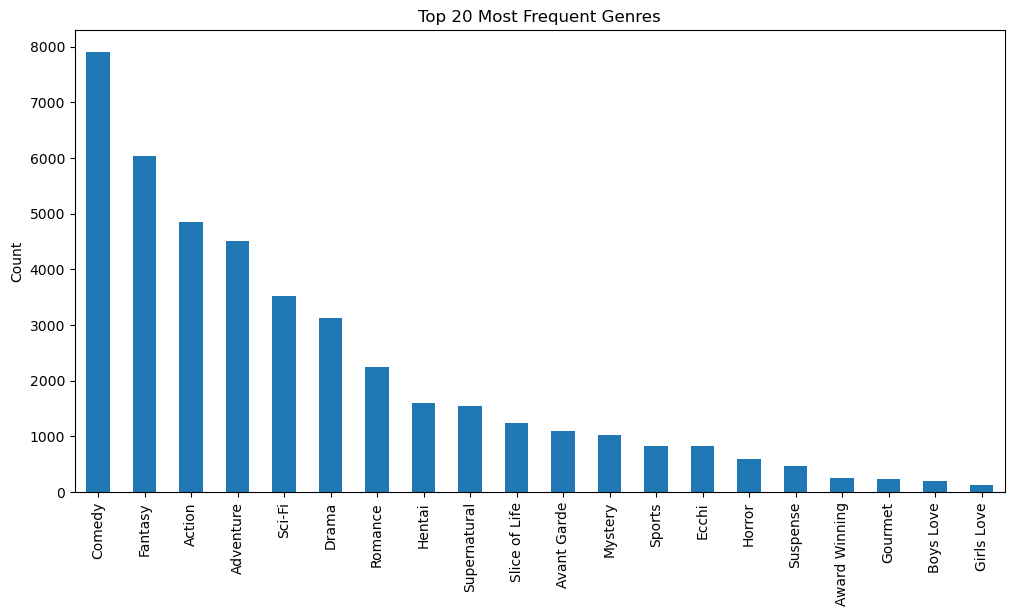

In [8]:
#Break genres into seperated columns
all_genres = df['genres'].str.split(', ').explode()

# Remove anime without genres
all_genres = all_genres[all_genres.str.strip() != ""]

plt.figure(figsize=(12, 6))
all_genres.value_counts().head(20).plot(kind='bar')
plt.title('Top 20 Most Frequent Genres')
plt.ylabel('Count')
plt.show()

# Feature engineering <a class="anchor" id="feature-engineering"></a>

1. Categorical features (Genres)

Here I used TF IDF (Term Frequency-Inverse Document Frequency) for feature engineer because one-hot encoding (dummies) will treat all genres equally. But some genres should be weighted more than other, because they are more popular. 

For example, there are more Action anime than Vampire or Cyberpunk anime and so on.

In [9]:
#Seperated genres by comma
tfidf = TfidfVectorizer(token_pattern=r'[^,]+')
genre_matrix = tfidf.fit_transform(df['genres'])

2. Numerical features (members, scores)

Since the members and scores the higher ther better, and the rank and popularity are the lower the better, so I use the log transformation to handle this. 

In [10]:
# Log transformation to handle the skewed 'members' data
df['log_members'] = np.log1p(df['members'])

# Normalize
scaler = MinMaxScaler()
numerical_features = scaler.fit_transform(df[['score', 'log_members']])


In [11]:
# Combine both, I want more weight on genres than scores
combined_features = hstack([genre_matrix * 2.0, numerical_features])

# Machine Learning Algorithms

1. KNN <a class="anchor" id="knn"></a>

Metrics = cosine: Considers each anime as a vector. Then calculate the angle distance instead of euclidean distance, which means it focuses more on "how similar both anime is ?" rather than "how far this anime from another in the space?".

Algorithm = brute: Calculate the distance from the anime given with all single other anime in the dataset. 

In [12]:
# Initialize and fit the KNN model
model_knn = NearestNeighbors(metric='cosine', algorithm='brute')
model_knn.fit(combined_features)


NearestNeighbors(algorithm='brute', metric='cosine')

In [13]:
def get_recommendations_multi(titles_list, n_recs=10):
    # 1. Get the indices for all requested titles
    indices = []
    for t in titles_list:
        try:
            idx = df[df['title'] == t].index[0]
            indices.append(idx)
        except IndexError:
            print(f"Warning: Anime '{t}' not found.")
            
    if not indices:
        return "No valid titles found."

    # 2. Convert to CSR to allow slicing [indices]
    csr_features = combined_features.tocsr()
    user_vectors = csr_features[indices]

    # 3. Calculate the MEAN and fix the TypeError
    # .mean() returns a np.matrix, which KNN hates. 
    # We use np.asarray() to convert it back to a standard array.
    average_vector = np.asarray(user_vectors.mean(axis=0))

    # 4. Use KNN to find neighbors
    distances, neighbor_indices = model_knn.kneighbors(average_vector, n_neighbors=n_recs + len(titles_list))

    # 5. Filter out the anime the user already mentioned
    recs = []
    for i in neighbor_indices[0]:
        if i not in indices:
            recs.append(i)
            
    return df.iloc[recs[:n_recs]][['title', 'genres', 'score', 'members']]

In [14]:
get_recommendations_multi(['Naruto', 'Death Note', 'Overlord'])

,title,genres,score,members
6451,Hunter x Hunter (2011),"Action, Adventure, Fantasy",9.03,3111578
11,One Piece,"Action, Adventure, Fantasy",8.73,2608442
1574,Naruto: Shippuuden,"Action, Adventure, Fantasy",8.28,2691247
14205,Dororo,"Action, Adventure, Fantasy",8.26,1347676
26571,Ore dake Level Up na Ken Season 2: Arise from ...,"Action, Adventure, Fantasy",8.61,705886
22648,Ore dake Level Up na Ken,"Action, Adventure, Fantasy",8.21,1065574
7793,Magi: The Kingdom of Magic,"Action, Adventure, Fantasy",8.20,887984
8973,Nanatsu no Taizai,"Action, Adventure, Fantasy",7.61,2178751
7114,Magi: The Labyrinth of Magic,"Action, Adventure, Fantasy",8.00,1107158
115,Hunter x Hunter,"Action, Adventure, Fantasy",8.43,636954


2. Hierarchical Clustering <a class="anchor" id="hc"></a>

In [15]:
# To keep the graph readable, we will only cluster a subset (e.g., the top 50 anime)
# Otherwise, the Dendrogram will be too crowded to see.
subset_df = df.head(50)
subset_features = combined_features.toarray()[:50]

# Initialize the model
cluster_model = AgglomerativeClustering(n_clusters=5, metric='cosine', linkage='average')
cluster_labels = cluster_model.fit_predict(subset_features)

# Add the cluster results back to our subset dataframe
subset_df['cluster'] = cluster_labels

C:\Users\USER\AppData\Local\Temp\ipykernel_20368\2655195562.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset_df['cluster'] = cluster_labels


In [16]:
def draw_neighborhood_dendrogram(target_title, n_neighbors=10):
    # 1. Find the target anime's index
    try:
        target_idx = df[df['title'] == target_title].index[0]
    except IndexError:
        print(f"Anime '{target_title}' not found.")
        return

    # 2. Use KNN to find the nearest neighbors
    distances, indices = model_knn.kneighbors(
        combined_features.tocsr()[target_idx].toarray(), 
        n_neighbors=n_neighbors
    )
    
    # 3. Create a subset of the dataframe and features
    neighbor_indices = indices[0]
    subset_df = df.iloc[neighbor_indices].copy()
    subset_features = combined_features.tocsr()[neighbor_indices].toarray()

    # 4. Calculate Linkage
    Z = sch.linkage(subset_features, method='average', metric='cosine')

    # 5. Plot the Dendrogram
    plt.figure(figsize=(12, 8))
    plt.title(f"Similarity Tree: Anime related to '{target_title}'", fontsize=15)
    
    sch.dendrogram(
        Z, 
        labels=subset_df['title'].values, 
        leaf_rotation=90, 
        leaf_font_size=10,
    )
    
    plt.ylabel("Cosine Distance (Lower = More Similar)")
    plt.tight_layout()
    plt.show()



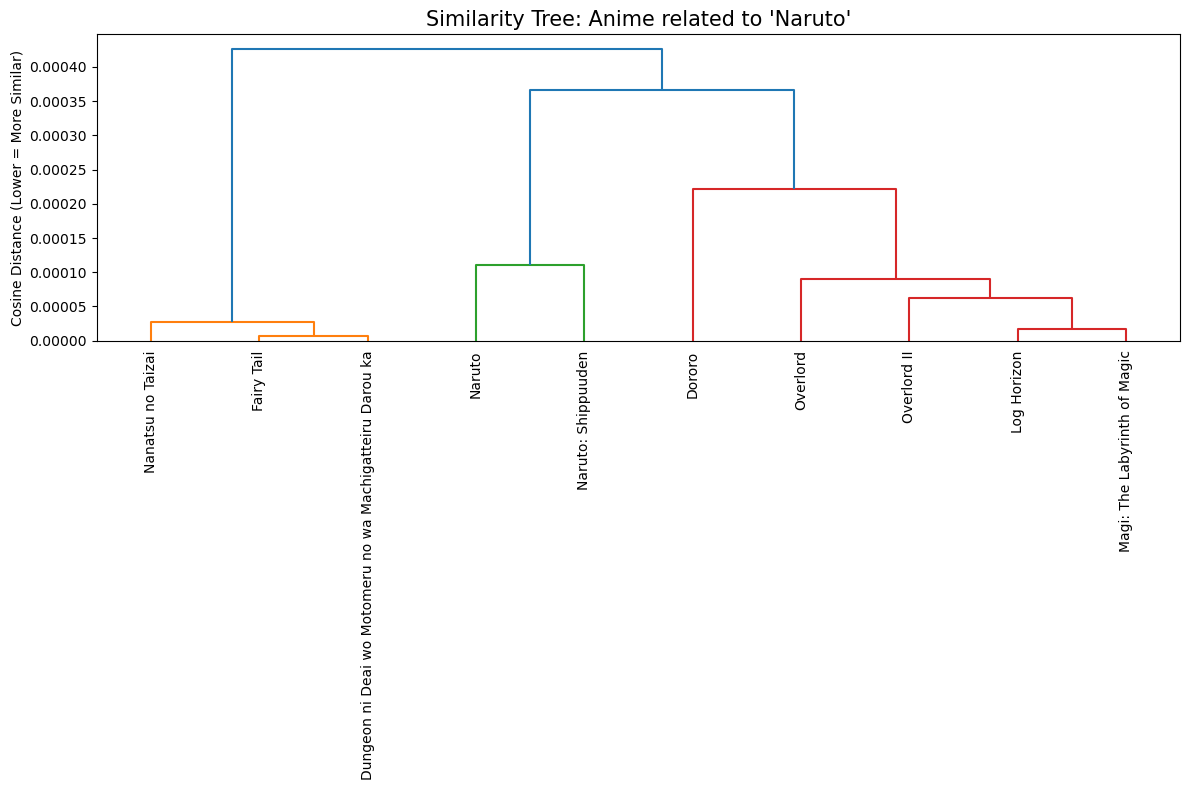

In [17]:
# Test
draw_neighborhood_dendrogram("Naruto")

# Program <a class="anchor" id="program"></a>

In [18]:
# Type in your favorite anime titles, be careful because this is case-sensitive
user_input = input("Enter your favorite anime titles, separated by commas: \n  (If you want to reference more than one anime, use knn. If you use hierarchical clustering, only the first on the list count)\n ")

# .strip() removes whitespace, .lower() makes it case-insensitive
recommender_type = input("Which algorithm you want to use? Press 'k' for k-nearest neighbour and 'h' for hierarchical clustering:\n ").strip().lower()


# .strip() removes accidental spaces at the beginning or end
fav_list = [title.strip() for title in user_input.split(',')]

print(f"Searching recommendations for: {fav_list}\n")

# Now use your preferred algorithm
if recommender_type == 'k':
    results = get_recommendations_multi(fav_list)
    display(results)
    
elif recommender_type == 'h':
    results = draw_neighborhood_dendrogram(fav_list[0])
    display(results)
    

Enter your favorite anime titles, separated by commas: 
  (If you want to reference more than one anime, use knn. If you use hierarchical clustering, only the first on the list count)
 Death Note
Which algorithm you want to use? Press 'k' for k-nearest neighbour and 'h' for hierarchical clustering:
 k
Searching recommendations for: ['Death Note']



,title,genres,score,members
2721,Death Note: Rewrite,"Supernatural, Suspense",7.72,222133
7490,Mirai Nikki: Redial,"Supernatural, Suspense",7.28,369427
27771,Necronomico no Cosmic Horror Show,"Supernatural, Suspense",6.10,11455
12793,Warau Salesman Special Program,"Supernatural, Suspense",6.30,1038
15520,Jibaku Shounen Hanako-kun,Supernatural,7.82,673364
23574,Jibaku Shounen Hanako-kun 2,Supernatural,7.93,93253
4732,"Kuroshitsuji: Sono Shitsuji, Kougyou",Supernatural,7.51,121871
6488,Ao no Exorcist: Kuro no Iede,Supernatural,7.27,141898
28354,Jibaku Shounen Hanako-kun 2 Part 2,Supernatural,8.03,48299
15495,Totsukuni no Shoujo,Supernatural,7.57,68399


# Note

If you do not like (or know) any anime, you can use a few anime that I list below for testing. Please be careful because models are case-sensitive. So just copy and paste for best use (and I have already tested it, there is no error).  

As a single anime: Fairy Tail / Dororo / Tokyo Ghoul / Death Note / One Piece / Dragon Ball

As a list: (All above seperated by comma). For example: Log Horizon, Drifters, Jujutsu Kaisen, Kimetsu no Yaiba